<a href="https://colab.research.google.com/github/knobelsp/BlandAltman/blob/main/Copy_of_BlandAltman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bland-Altman: a statistically sound alternative to scatterplots


**We've all done it...
that is, tested our dataset / algorithm output / etc. against a reference with a simple $x$ vs $y$ scatterplot**.
Perhaps we fit a line to the results, or calculated the correlation coefficient. 

*But is this really the right way to test if our new data is comparable to a reference?* 

**The answer is no**, and there is substantial literature to support this (e.g.
<a href="https://doi.org/10.1364/OE.26.007404">Seegers et al., 2018</a>). But that doesn't stop many of us from making a simple plot, calculating default statistics and calling it a day. Perhaps our motivation is the perceived approachability and simplicity. Maybe we're not aware of the statistical unsuitability. Or maybe we calculated an $R^2$ value of 0.97, and that sounds good enough, right?
 

## This notebook demonstrates a simple alternative: Bland-Altman plots

**The fundamental problem we're addressessing is "can measurement $y$ replace measurement $x$".** For example, we might have geophysical parameters determined by an algorithm that analyzes satellite data that we're comparing to ground based measurements. Or maybe we have the results of a trained neural network that we wish to assess against independent validation data. In these cases, we have paired measurements, ie $[(x_1,y_1),(x_2,y_2),(x_3,y_3),...]$ that we would like to assess in aggregate. No single numerical metric can wholly express the 'quality' of the comparison. We instead need several metrics, such as:
 - mean bias between $x$ and $y$
 - scatter in the relationship between $x$ and $y$
 - scale dependence of bias and scatter

While all of these things can be visually inferred from a scatterplot, they are more directly expressed with a *Bland-Altman plot* and corresponding analysis. These techniques are described in <a href="https://doi.org/10.2307/2987937">Altman and Bland, 1983</a>, <a href="https://doi.org/10.1016/S0140-6736(86)90837-8">Bland and Altman, 1986</a> and many subsequent publications (e.g. <a href="https://dx.doi.org/10.1016/j.ijnurstu.2009.10.001">Bland and Altman, 2010</a>, 
<a href="https://doi.org/10.1093/clinchem/48.5.799">Dewitte et al., 2002</a>). An alternative name for this approach is the *Tukey mean-difference plot* and other field specific names, and there is ample evidence of similar analysis that predates Bland and Altman's highly cited papers (e.g. <a href="http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.632.3728&rep=rep1&type=pdf">Eksborg, 1981</a>). 

As we will demonstrate, scatterplots are less effecive at assessing agreement between a pair of measurement types than a Bland-Altman plot. Even more problemmatic are the statistical metrics that are often used in conjunction, including:
 - linear regression (i.e. y = mx +b fits)
 - correlation coefficients (such as the Pearson' linear or the Spearman's rank correlation coefficients)
 - root mean square error (RMSE)
 
The abovementioned literature discusses the inadaquacy of these metrics. **This notebook is a graphical demonstration, with side by side comparisons with various datasets.**

### Before starting, compile this code...

In [2]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats

In [3]:
#Routine to plot, side by side, 2D histograms of paired data as bland-altman and scatterplot. 
#It also calculates relevant analysis metrics.
#Takes as input:
# x_input: array of X data values
# y_input: corresponding array of Y data values, ie [X[1],Y[1]]. len(x_input)=len(y_input)
# label: text label for plotting, default is emtpy ('')
# saveplot: set to 1 to save plot, default is (0)
# scat: default (0) is to make a 2d histogram, regular scatterplot if set to 1
# binscale: default (1) is a scaling factor for how many bins to include in a 2d histogram

def plot_BAvsScat(x_input,y_input,label='',saveplot=0, scat=0, binscale=1.0):
    #deal with inputs
    xx=np.asarray(x_input)
    yy=np.asarray(y_input)
    
    #compute Bland-Altman axes
    jj=(xx+yy)/2  #paired mean
    kk=yy-xx      #bias

    #compute Bland-Altman metrics
    meanbias=np.mean(kk)
    stdbias=np.std(kk)
    LOAlow= meanbias - (stdbias) #lower limit of agreement (LOA), at two sigma
    LOAhgh= meanbias + (stdbias) #upper limit of agreement (LOA), at two sigma    
    ba_stat, ba_p = stats.spearmanr(jj, kk)
    ba_independ = ba_p > 0.05
    if ba_independ:
        print('Bias INDEPENDENT of paired mean, r:%.3f' % ba_stat)
    else:
        print('Bias DEPENDENT on paired mean, r:%.3f' % ba_stat)

    #compute regression metrics
    regress_result=stats.linregress(xx, yy)
    spearman_r=stats.spearmanr(xx,yy)
    r_spear=round((spearman_r.correlation)*10000)/10000.
    pearson_r=stats.pearsonr(xx,yy)
    r_pear=round((pearson_r[0])*10000)/10000.

    #stuff to make plotting nice  
    nbin=int(0.5*binscale*np.sqrt(len(xx))) #find appropriate binning dimensions, relevant for 2dhist
    min_kk=meanbias - 3.*(stdbias)
    max_kk=meanbias + 3.*(stdbias) 
    
    if scat == 0:
        jj_sorted= np.sort(jj)  # sort paired mean data in ascending order
        min_jj=jj_sorted[int(0.01*len(xx))]
        max_jj=jj_sorted[int(0.99*len(xx))]
    else:
        min_jj=min(jj)
        max_jj=max(jj)
    gamma=0.5
    
    #set up colors
    if scat == 0:
        lineclr='white'
        loaclr='yellow'
        fitclr='cyan'
    else: 
        lineclr='black'
        loaclr='green'
        fitclr='magenta'
    
    #make nice labels for plotting
    #...for Bland-Altman
    meanbias=round(meanbias*100000)/100000.
    LOAlow=round(LOAlow*10000)/10000.
    LOAhgh=round(LOAhgh*10000)/10000.  
    ba_rankcorr=round((ba_stat)*10000)/10000.
    if ba_independ:
        txt1='Mean bias: '+str(meanbias)+' ('+fitclr+' dashed line)'
        txt2='LOA: ['+str(LOAlow)+','+str(LOAhgh)+'] ('+loaclr+' dashed lines)'
    else:
        txt1='Bias DEPENDENT on paired mean'
        txt2='Rank correlation: '+str(ba_rankcorr)
        
    #...regression
    slope=round(regress_result.slope*10000)/10000.
    intercept=round(regress_result.intercept*10000)/10000.
    txt3='y = '+str(slope)+'x + '+str(intercept)+' ('+fitclr+' dashed line)'
    txt4='Linear correlation: '+str(r_pear)
    txt5='Rank correlation: '+str(r_spear)
       
    #plotting setup
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,6))
    fig.suptitle(label, fontsize=22)    
    
    #plot bland-altman
    if scat == 0:
        h=ax1.hist2d(jj,kk, bins=(nbin,nbin), norm=mcolors.PowerNorm(gamma), cmap=plt.cm.inferno,
                   range=[[min_jj, max_jj], [min_kk, max_kk]])

        fig.colorbar(h[3], ax=ax1)
    else:
        h=ax1.scatter(jj,kk)
        ax1.set_xlim([min_jj, max_jj])
        ax1.set_ylim([min_kk, max_kk])

    ax1.set_title('Bland-Altman plot', fontsize=20)
    ax1.set_xlabel('Paired mean, $(x+y)/2$', fontsize=18)
    ax1.set_ylabel('Bias, $y-x$', fontsize=18)
    
    ax1.plot([min_jj,max_jj],[0,0],color=lineclr,linestyle='solid',linewidth=4.0)
    if ba_independ:
        ax1.plot([min_jj,max_jj],[meanbias,meanbias],color=fitclr,linestyle='dashed',linewidth=3.0)
        ax1.plot([min_jj,max_jj],[LOAlow,LOAlow],color=loaclr,linestyle='dashed',linewidth=2.0)
        ax1.plot([min_jj,max_jj],[LOAhgh,LOAhgh],color=loaclr,linestyle='dashed',linewidth=2.0)
    ax1.text(0.04, 0.95, txt1, horizontalalignment='left', color=lineclr,verticalalignment='center', 
             transform=ax1.transAxes,fontsize=12)
    ax1.text(0.04, 0.90, txt2, horizontalalignment='left', color=lineclr,verticalalignment='center', 
             transform=ax1.transAxes,fontsize=12)   

    #make scatterplot
    if scat == 0:
        g=ax2.hist2d(xx,yy, bins=(nbin,nbin), norm=mcolors.PowerNorm(gamma), cmap=plt.cm.inferno,
               range=[[min_jj, max_jj], [min_jj, max_jj]])
        fig.colorbar(g[3], ax=ax2)
        xax_move=0.3
    else:
        g=ax2.scatter(xx,yy)
        ax2.set_xlim([min_jj, max_jj])
        ax2.set_ylim([min_jj, max_jj])
        xax_move=0.0
        
    ax2.set_title('Scatterplot', fontsize=20)
    ax2.set_xlabel('$x$', fontsize=18)
    ax2.set_ylabel('$y$', fontsize=18)
    ax2.plot([min_jj,max_jj],[min_jj,max_jj],color=lineclr,linestyle='solid',linewidth=4.0)

    #find regression line
    min_fit_yy=regress_result.slope*min_jj + regress_result.intercept
    max_fit_yy=regress_result.slope*max_jj + regress_result.intercept
    ax2.plot([min_jj,max_jj],[min_fit_yy,max_fit_yy],color=fitclr,linestyle='dashed',linewidth=3.0)
    ax2.text(xax_move+1.24, 0.95, txt3, horizontalalignment='left', color=lineclr,
             verticalalignment='center', transform=ax1.transAxes,fontsize=12)
    ax2.text(xax_move+1.24, 0.90, txt4, horizontalalignment='left', color=lineclr,
             verticalalignment='center', transform=ax1.transAxes,fontsize=12)
    ax2.text(xax_move+1.24, 0.85, txt5, horizontalalignment='left', color=lineclr,
             verticalalignment='center', transform=ax1.transAxes,fontsize=12)   

    #save figure if savefig=1
    if saveplot == 1:
        figname=label+"_blandaltman.pdf"
        print('Saved figure to:',figname)
        fig.savefig(figname)

    #violà!
    plt.show()



### The Bland-Altman technique

The Bland-Altman plot differs from a regular scatterplot in that the bias between each pair of measurements is plotted against the paired mean. Rather than plotting $x$ versus $y$ for paired measurements $[(x_1,y_1),(x_2,y_2),(x_3,y_3),...]$, we instead calculated the paired mean ($m$) and bias ($b$):

$m = \frac{x+y}{2}$

$b = y - x $

Instead of plotting $x$ vs $y$, we plot $m$ versus $b$. While the resulting Bland-Altman plot contains the same information as the scatterplot it clearly and independently visualizes the most relevant and robust metrics for comparisons of measurement techniques: bias, scatter, and scale dependence.

We'll describe those in detail in a moment, but for now let's start with a simple example based on randomly generated numbers. 


Bias INDEPENDENT of paired mean, r:0.065


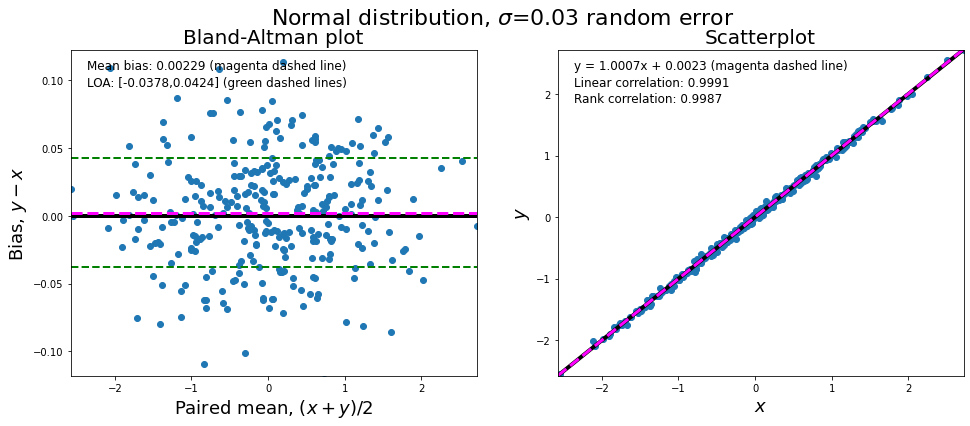

In [4]:
leng=300
source=np.random.standard_normal(size=(leng)) #this is the true value
random_error=0.03 #set a random error of 3% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx= source + xx_error_rand #x is the true value (source) plus random errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy= source + yy_error_rand #y is the true value (source) plus random errors

plot_BAvsScat(xx,yy,label='Normal distribution, $\sigma$=0.03 random error',scat=1)

Above, we show the Bland-Altman plot at left and a standard scatterplot at right. The source data are randomly generated from a zero mean, $\sigma$=1 Gaussian normal distribution. 'Measurements' of these data, expressed in $x$ and $y$, include random errors from a normal distribution with $\sigma$=0.03.

The only differences between $x$ and $y$ are random errors with no systemmatic bias. The mean of the $y-x$ bias is therefore close to zero, as it clear in the Bland-Altman plot, where it has been labeled with a dashed magenta line. It is also shown in the scatterplot at right, and in the linear fit to the data (also a magenta dashed line) which is close to $y = 1.0x + 0.0$. Both the linear (Pearson) and rank (Spearman) correlation coefficients are 'high', although it is difficult to connect the meaning of those values to the data itself. The **mean bias, $\bar{b}$**, on the other hand, is a metric expressed in the units of the measurement, and clearly shown in the Bland-Altman plot. 

A significant difference between the Bland-Altman plot and scattplot is how random errors (scatter) are represented. The Bland-Altman plot shows this clearly, and from this we can calculate the **Limits of Agreement, LOA**:

$LOA = [\bar{b}-s, \bar{b}+s]$

where $s$ is the standard deviation of $b$. In this case, $LOA \approx [-0.424, 0.424]$, which is the squared sum of the $\sigma$=0.03 random errors for $x$ and $y$. 

**The LOA expresses expectations of agreement between $x$ and $y$. We can expect the $y-x$ difference to fall within this range roughly 68.2% of the time** (see below for further qualifications).

Like $\bar{b}$, the LOA is expressed in the units of measurement. There is no equivalent in a scatterplot, linear regression to $x$ and $y$, or correlation coefficients. The latter are, of course, close to 1 for minimal bias and scatter systems, but multiple factors can cause the correlation coefficient to decrease. 


Bias INDEPENDENT of paired mean, r:-0.037


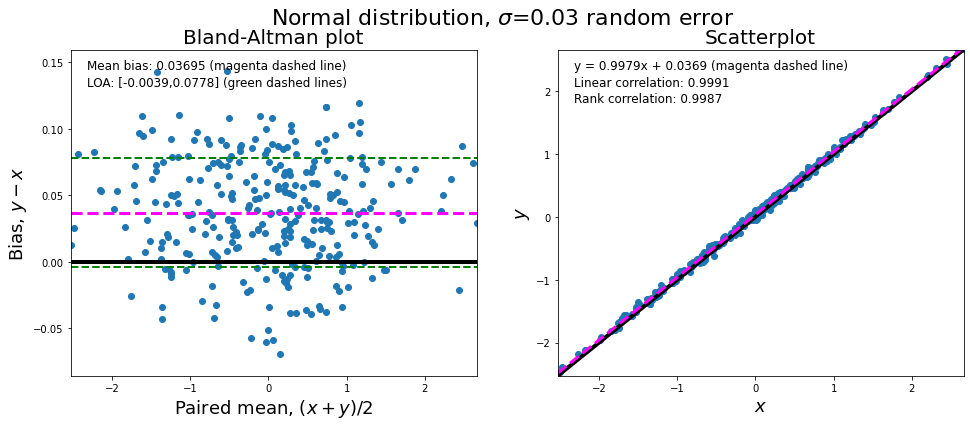

In [5]:
leng=300
source=np.random.standard_normal(size=(leng)) #this is the true value
random_error=0.03 #set a random error of 3% as wide as a standard normal distribution

xx_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
xx_error_system = -0.03
xx= source + xx_error_rand + xx_error_system #x is the true value (source) plus random errors

yy_error_rand=random_error*np.random.standard_normal(size=(leng)) #generate random error for measurement x
yy= source + yy_error_rand #y is the true value (source) plus random errors

plot_BAvsScat(xx,yy,label='Normal distribution, $\sigma$=0.03 random error',scat=1)

Bias INDEPENDENT of paired mean, r:-0.002
Saved figure to: Normal distribution, 20% random error_blandaltman.pdf


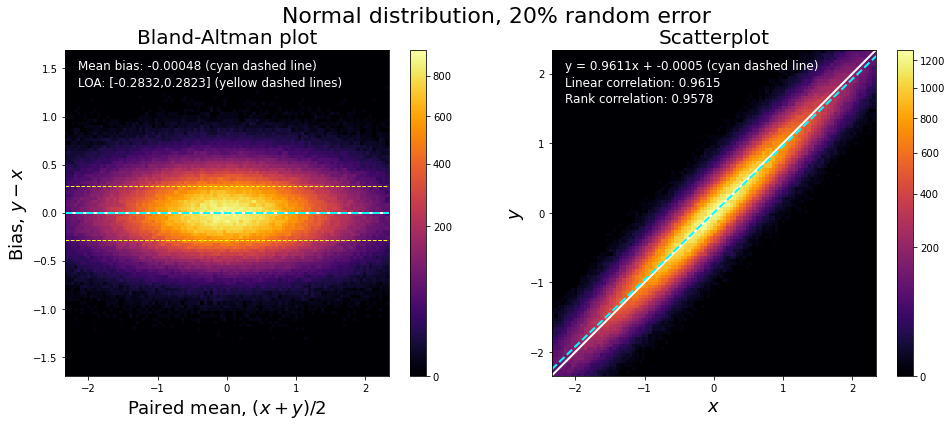

In [ ]:
leng=1000000
source=np.random.standard_normal(size=(leng)) #this is the true value
this_leng=len(source)

random_error=0.20

xx_error_rand=random_error*np.random.standard_normal(size=(this_leng))
xx_error_syst=0.0
xx= source + xx_error_rand

yy_error_rand=random_error*np.random.standard_normal(size=(this_leng))
yy_error_syst=0.0
yy= source + yy_error_rand 

plot_results(xx,yy,'Normal distribution, 20% random error',1)

Bias INDEPENDENT of paired mean, r:0.001
Saved figure to: Lognormal distribution, 3% random error_blandaltman.pdf


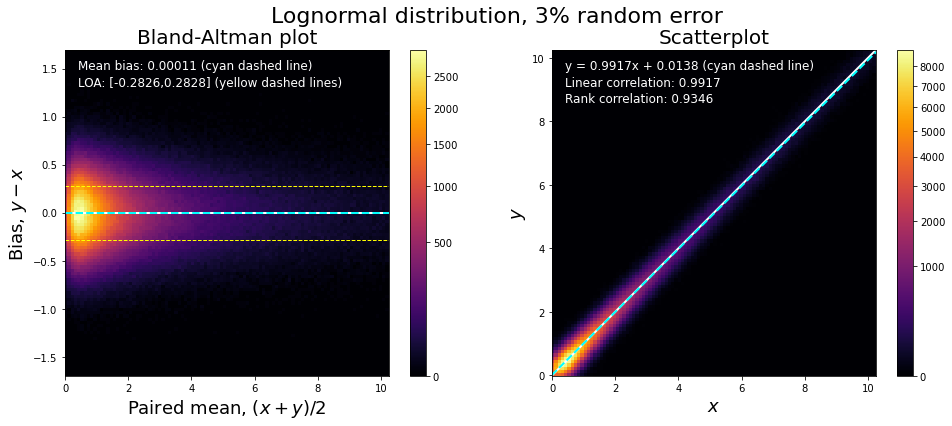

In [ ]:
leng=1000000
source=np.random.lognormal(0,1,size=(leng)) #this is the true value
this_leng=len(source)

random_error=0.20

xx_error_rand=random_error*np.random.standard_normal(size=(this_leng))

xx_error_syst=0.0
xx= source + xx_error_rand

yy_error_rand=random_error*np.random.standard_normal(size=(this_leng))

yy_error_syst=0.0
yy= source + yy_error_rand

plot_results(xx,yy,'Lognormal distribution, 3% random error',1)

Bias INDEPENDENT of paired mean, r:0.001
Saved figure to: Lognormal distribution capped at 2, 3% random error_blandaltman.pdf


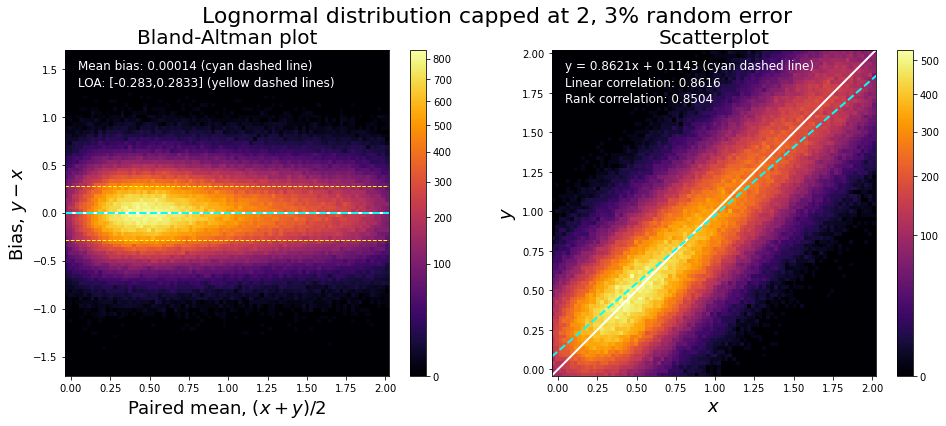

In [ ]:
leng=1000000
source=np.random.lognormal(0,1,size=(leng)) #this is the true value
source=source[source <=2]
this_leng=len(source)


random_error=0.20

xx_error_rand=random_error*np.random.standard_normal(size=(this_leng))
#xx_error_rand=random_error*np.random.lognormal(0,1,size=(leng))

xx_error_syst=0.0
xx= source + xx_error_rand

yy_error_rand=random_error*np.random.standard_normal(size=(this_leng))
#yy_error_rand=random_error*np.random.lognormal(0,1,size=(leng))

yy_error_syst=0.0
yy= source + yy_error_rand

plot_results(xx,yy,'Lognormal distribution capped at 2, 3% random error',1)